<a href="https://colab.research.google.com/github/michelle-lieng/fashion-query/blob/main/fashion-query.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First download kaggle data on google collab. Followed this https://www.kaggle.com/discussions/general/74235

In [ ]:
! pip install -q kaggle

# upload the kaggle.json file downloaded from making an API token
from google.colab import files
files.upload()

# make a directory named kaggle and copy kaggle.json file there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# Change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json

# downloaded the h-and-m dataset from kaggle
! kaggle competitions download -c h-and-m-personalized-fashion-recommendations

Saving kaggle.json to kaggle.json
100% 28.7G/28.7G [03:57<00:00, 80.0MB/s]
100% 28.7G/28.7G [03:57<00:00, 130MB/s] 


In [ ]:
# Create a directory named data
! mkdir data
# unzip data there
! unzip h-and-m-personalized-fashion-recommendations.zip -d data

mkdir: cannot create directory ‘data’: File exists
Archive:  h-and-m-personalized-fashion-recommendations.zip
replace data/articles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

For trialing to keep it faster just going to use images from folders 010 to 020

In [ ]:
image_folders = []
for x in range (10,25):
  image_folders.append("0" + str(x))

In [ ]:
import os

def get_images():
  image_locations = []

  for image_folder in image_folders:
    image_locations.append(f'/content/data/images/{image_folder}')

  filenames = []
  image_full_paths = []
  image_numbers = []
  for image_location in image_locations:
    for filename in os.listdir(image_location):
      filenames.append(filename)
      image_full_paths.append(f'{image_location}/{filename}')
      image_numbers.append(int(filename.rstrip('.jpg')))

  return image_numbers, filenames, image_full_paths

image_numbers, filenames, image_full_paths = get_images()

In [ ]:
# make a df with image number names and image full paths

import pandas as pd
df_data = pd.DataFrame(
    {'article_id': image_numbers,
     'image_full_path': image_full_paths
     })
df_data.head()

,article_id,image_full_path
0,108775051,/content/data/images/010/0108775051.jpg
1,108775015,/content/data/images/010/0108775015.jpg
2,108775044,/content/data/images/010/0108775044.jpg
3,114428026,/content/data/images/011/0114428026.jpg
4,118458004,/content/data/images/011/0118458004.jpg


Load excel sheet and add as metadata for the image vectors and the product description vectors

NOTE: !!!!!!!!! I'm loading everything into a df including the vectors because it is easy to visualise before I load it into the vector store. This is an optional step. I also had to convert the tensors into numpys so they can be viewed in the df and then loaded it to pinecone which is okay to do and optional just for visibility -> doing it this way doesn't change anything

In [ ]:
# Load metadata
metadata = pd.read_csv('/content/data/articles.csv')

# filter for metadata for the images selected from files 010 to 020
metadata.loc[metadata["article_id"].isin(image_numbers)]

# add column for image path
metadata = pd.merge(metadata, df_data, on='article_id')

metadata.head()  # To check the first few rows

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,image_full_path
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,/content/data/images/010/0108775015.jpg
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,/content/data/images/010/0108775044.jpg
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,/content/data/images/010/0108775051.jpg
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",/content/data/images/011/0110065001.jpg
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",/content/data/images/011/0110065002.jpg


Preprocess images and convert them into vectors

In [ ]:
pip install -q transformers torch pandas openpyxl

Using base model CLIP-ViT-Base-Patch32 (from Hugging Face's Transformers) at the moment because less computational resources but later shall change to ViT-L-14 (from mlfoundations/open_clip) because this is the model that Marqo uses. Also the base model I'm using right now is not good for commercial purposes.

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

# Initialize CLIP
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Tensor - a data structure that deep learning models can process

Below I converted the tensor to a numpy array so I can load it into the data frame for visibility - this is an optional step and unneccessary but if you load it into pinecone as a numpy array it doesn't matter because pinecone only cares about the numbers stored

Flattening Vectors: Since your vectors are in the shape (1, 512), they're effectively 2D arrays with a single row. Pinecone expects a flat vector for each ID, so you'll need to flatten these vectors to 1D arrays of shape (512,). The flatten_vector function handles this by calling .flatten() on each vector, which is a NumPy method to convert any array into a 1D array.

In [ ]:
# Function to convert images to vectors
def image_to_vector(image_path):
    image = Image.open(image_path) # open image
    # prepare image by converting image to a Pytorch tensor ("pt" stands for pytorch)
    inputs = processor(images=image, return_tensors="pt")
    # tells pytorch not to compute or store gradients which is only useful for model training
    # no applying for models as then we can save memory consumption and computational load
    with torch.no_grad():
    # get_image_features captures meaningful features from image - high dimensional representation of image's content
    # image_features is the tensor of extracted features - we refer to as the "vector" rep of image
        image_features = model.get_image_features(**inputs)
    # ensures tensor is on cpu and then convert tensor to numpy array
    return image_features.cpu().numpy()

# Adding a new column for image vectors
metadata['image_vector'] = metadata['image_full_path'].apply(lambda x: image_to_vector(x))

# view df
metadata.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,image_full_path,image_vector
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,/content/data/images/010/0108775015.jpg,"[[-0.0033354983, 0.07843107, -0.031240866, 0.3..."
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,/content/data/images/010/0108775044.jpg,"[[-0.20662282, 0.12165272, 0.03923227, 0.38435..."
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,/content/data/images/010/0108775051.jpg,"[[-0.3068158, 0.13818404, 0.021934822, 0.38900..."
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",/content/data/images/011/0110065001.jpg,"[[0.19969906, -0.054368943, -0.09821862, -0.21..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",/content/data/images/011/0110065002.jpg,"[[-0.27130154, 0.008927628, 0.26284528, -0.354..."


Discovered from steps below that my tensor looks like

tensor([[-3.3355e-03,  7.8431e-02, -3.1241e-02,  3.5649e-01, ... ]])

with batch size 1 and feature vector of 512 dimension

my numpy looks like this

array([[-3.33549827e-03,  7.84310699e-02, -3.12408656e-02, ... ]])

with shape (1, 512)


In [ ]:
# [EXTRA STEP] finding out the dimensions of my tensor and or the numpy given
def image_to_vector(image_path):
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
      image_features = model.get_image_features(**inputs)
    return image_features, image_features.cpu().numpy()

tensor, num = image_to_vector("/content/data/images/010/0108775015.jpg")

In [ ]:
# tensor
# tensor.size()
# torch.Size([1, 512])

In [ ]:
# num
num.shape
# (1, 512)
# after flatten (512,)

(512,)

Convert detail_desc to vector as well using CLIP

In [ ]:
# Function to convert text to vectors
def text_to_vector(text):
    inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True, max_length=77)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features.cpu().numpy()

# 'detail_desc' is the column with text to vectorize
metadata['product_text_vector'] = metadata['detail_desc'].apply(text_to_vector)

# view metadata
metadata.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,image_full_path,image_vector,product_text_vector
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,/content/data/images/010/0108775015.jpg,"[[-0.0033354983, 0.07843107, -0.031240866, 0.3...","[[0.25403407, 0.029576443, -0.4296341, 0.28082..."
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,/content/data/images/010/0108775044.jpg,"[[-0.20662282, 0.12165272, 0.03923227, 0.38435...","[[0.25403407, 0.029576443, -0.4296341, 0.28082..."
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,/content/data/images/010/0108775051.jpg,"[[-0.3068158, 0.13818404, 0.021934822, 0.38900...","[[0.25403407, 0.029576443, -0.4296341, 0.28082..."
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",/content/data/images/011/0110065001.jpg,"[[0.19969906, -0.054368943, -0.09821862, -0.21...","[[0.22491929, 0.28394523, -0.17528056, -0.0148..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",/content/data/images/011/0110065002.jpg,"[[-0.27130154, 0.008927628, 0.26284528, -0.354...","[[0.22491929, 0.28394523, -0.17528056, -0.0148..."


Load into a vectorstore -> going to use pinecone.

Pinecone supports storing metadata (scalar fields) along with vectors, which can be used for filtering directly within search queries. This allows you to perform similarity searches that are also filtered by scalar attributes (e.g., price range) in a single query. Pinecone takes care of the indexing and retrieval, providing a simplified workflow for complex queries.


In [ ]:
# install pinecone python client
!pip install -q pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.9/215.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
# initialize pinecone with api key
from pinecone import Pinecone, PodSpec

pc = Pinecone(api_key="3eecf93a-a510-45b4-bbf0-0ae3f773ca15")

First you need to create a vector index because you can store or query any vectors. An index in Pinecone is a space where you can store and query your vectors.

I created a starter index as I am using the free plan: https://docs.pinecone.io/guides/indexes/create-an-index

After that you would then upload vectors
with the index created. Each vector needs to be associated with a unique ID.

Then after you store all your information you can then query the vector db. You can perform similarity search queries against your index to find the most similar vectors to a given query vector.

In [ ]:
# Create a starter index index
# Make sure the dimension parameter matches the size of the vectors you will store.
"""
pc.create_index(
  name="qiri-index", # Set the correct dimension according to your vectors
  dimension=512,
  metric="cosine",
  spec=PodSpec(
    environment="gcp-starter"
  )
)
"""
# i already made it so now i just have to initialize it
pc_index = pc.Index("qiri-index")

In Pinecone, each unique ID is associated with a single vector. If you have two vectors for an article (one from an image and one from a product description), and you want to maintain them both under the same ID within the same index, you have a couple of options:

1. Combine the Vectors:
You can concatenate the image vector and the text vector into a single longer vector if the dimensions allowed by your Pinecone index can accommodate the total length. This approach is useful if you want to maintain a direct association between the image and its corresponding text within the same vector space, potentially strengthening the semantic relationships in searches.

2. Use Separate Indexes:
Another approach is to create two separate indexes: one for image vectors and another for text vectors. Each index would use the same article IDs, maintaining a conceptual link between the vectors in different spaces. This method allows you to search within image vectors and text vectors separately or in parallel, depending on your application's needs.

I'm going to combine the image and text vectors.

How to combine image and text embeddings for product similarity?
https://discuss.huggingface.co/t/how-to-combine-image-and-text-embedding-for-product-similarity/47761/1
- I’d recommend using CLIP which has a vision encoder and text encoder whose embedding space are aligned with each other: CLIP
- People have already fine-tuned CLIP on various domains, like fashion: patrickjohncyh/fashion-clip

i want to combining image and text vectors. I used the clip model to generate both embedding vision encoder and text encoder whose embedding space are aligned with each other so now I want to combine them what is the best way to do so?
- Concatenation and PCA are useful for keeping as much information as possible, with PCA helping to manage dimensionality.
- Averaging and Weighted Sum offer simplicity and are easily interpretable, with weighted sums adding flexibility.
- Neural Networks provide the most flexibility and potential for optimization but require the most resources.

In [ ]:
# doing weighted sum for combining the text and image vectors
metadata['combined_vector'] = 0.4 * metadata['image_vector'] + 0.6 * metadata['product_text_vector']
metadata.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,image_full_path,image_vector,product_text_vector,combined_vector
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,/content/data/images/010/0108775015.jpg,"[[-0.0033354983, 0.07843107, -0.031240866, 0.3...","[[0.25403407, 0.029576443, -0.4296341, 0.28082...","[[0.15108624, 0.049118295, -0.2702768, 0.31109..."
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,/content/data/images/010/0108775044.jpg,"[[-0.20662282, 0.12165272, 0.03923227, 0.38435...","[[0.25403407, 0.029576443, -0.4296341, 0.28082...","[[0.06977131, 0.06640696, -0.24208756, 0.32223..."
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,/content/data/images/010/0108775051.jpg,"[[-0.3068158, 0.13818404, 0.021934822, 0.38900...","[[0.25403407, 0.029576443, -0.4296341, 0.28082...","[[0.029694125, 0.07301949, -0.24900654, 0.3240..."
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",/content/data/images/011/0110065001.jpg,"[[0.19969906, -0.054368943, -0.09821862, -0.21...","[[0.22491929, 0.28394523, -0.17528056, -0.0148...","[[0.2148312, 0.14861958, -0.14445579, -0.09447..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",/content/data/images/011/0110065002.jpg,"[[-0.27130154, 0.008927628, 0.26284528, -0.354...","[[0.22491929, 0.28394523, -0.17528056, -0.0148...","[[0.026430957, 0.1739382, -3.0219555e-05, -0.1..."


In [ ]:
# checking the size of the combined vector
metadata['combined_vector'].iloc[1].shape

(1, 512)

In [ ]:
# rename to info_df
info_df = metadata

Uploading vectors and metadata using upsert: https://docs.pinecone.io/guides/data/upsert-data

In [ ]:
import numpy as np
def upsert_from_dataframe(df, pc_index):
    vectors_to_upsert = []

    for _, row in df.iterrows():
        article_id = str(row['article_id'])  # Ensure ID is a string
        # Ensure vector_values is a flat list of floats
        vector_values = np.array(row['combined_vector']).flatten().tolist()

        metadata = {
            'colour': str(row['colour_group_name']),
            'price': float(row['section_no'])
        }

        vectors_to_upsert.append({
            "id": article_id,
            "values": vector_values,
            "metadata": metadata
        })

    # Bulk upsert into Pinecone
    pc_index.upsert(vectors=vectors_to_upsert)

In [ ]:
upsert_from_dataframe(info_df, pc_index)

In [ ]:
# Function to convert text to vectors
def query_to_vector(text):
    inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True, max_length=77)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features.cpu().numpy().flatten().tolist()


query_vector = query_to_vector("red dress")

In [ ]:
query_response = pc_index.query(
    vector=query_vector,
    filter={
        #"colour": {"$eq": "Pink"},
        #"price": {"$lt": 50}
    },
    top_k=3,
    include_metadata=True
)

In [ ]:
# function if given image idea name give the location
def get_image_path_by_id(image_id, df = df_data):
    # Convert image_id to the correct type if necessary (e.g., if your image IDs are integers in the DataFrame)
    image_id = int(image_id)

    # Find the row in the DataFrame where the image_id matches
    matching_row = df[df['article_id'] == image_id]

    if not matching_row.empty:
        # Return the first matching image path
        return matching_row['image_full_path'].iloc[0]
    else:
        # Return None or raise an error if the image_id is not found
        return None

ID: 212629043, Colour: Red, Price: 51.0, Score: 0.54469347


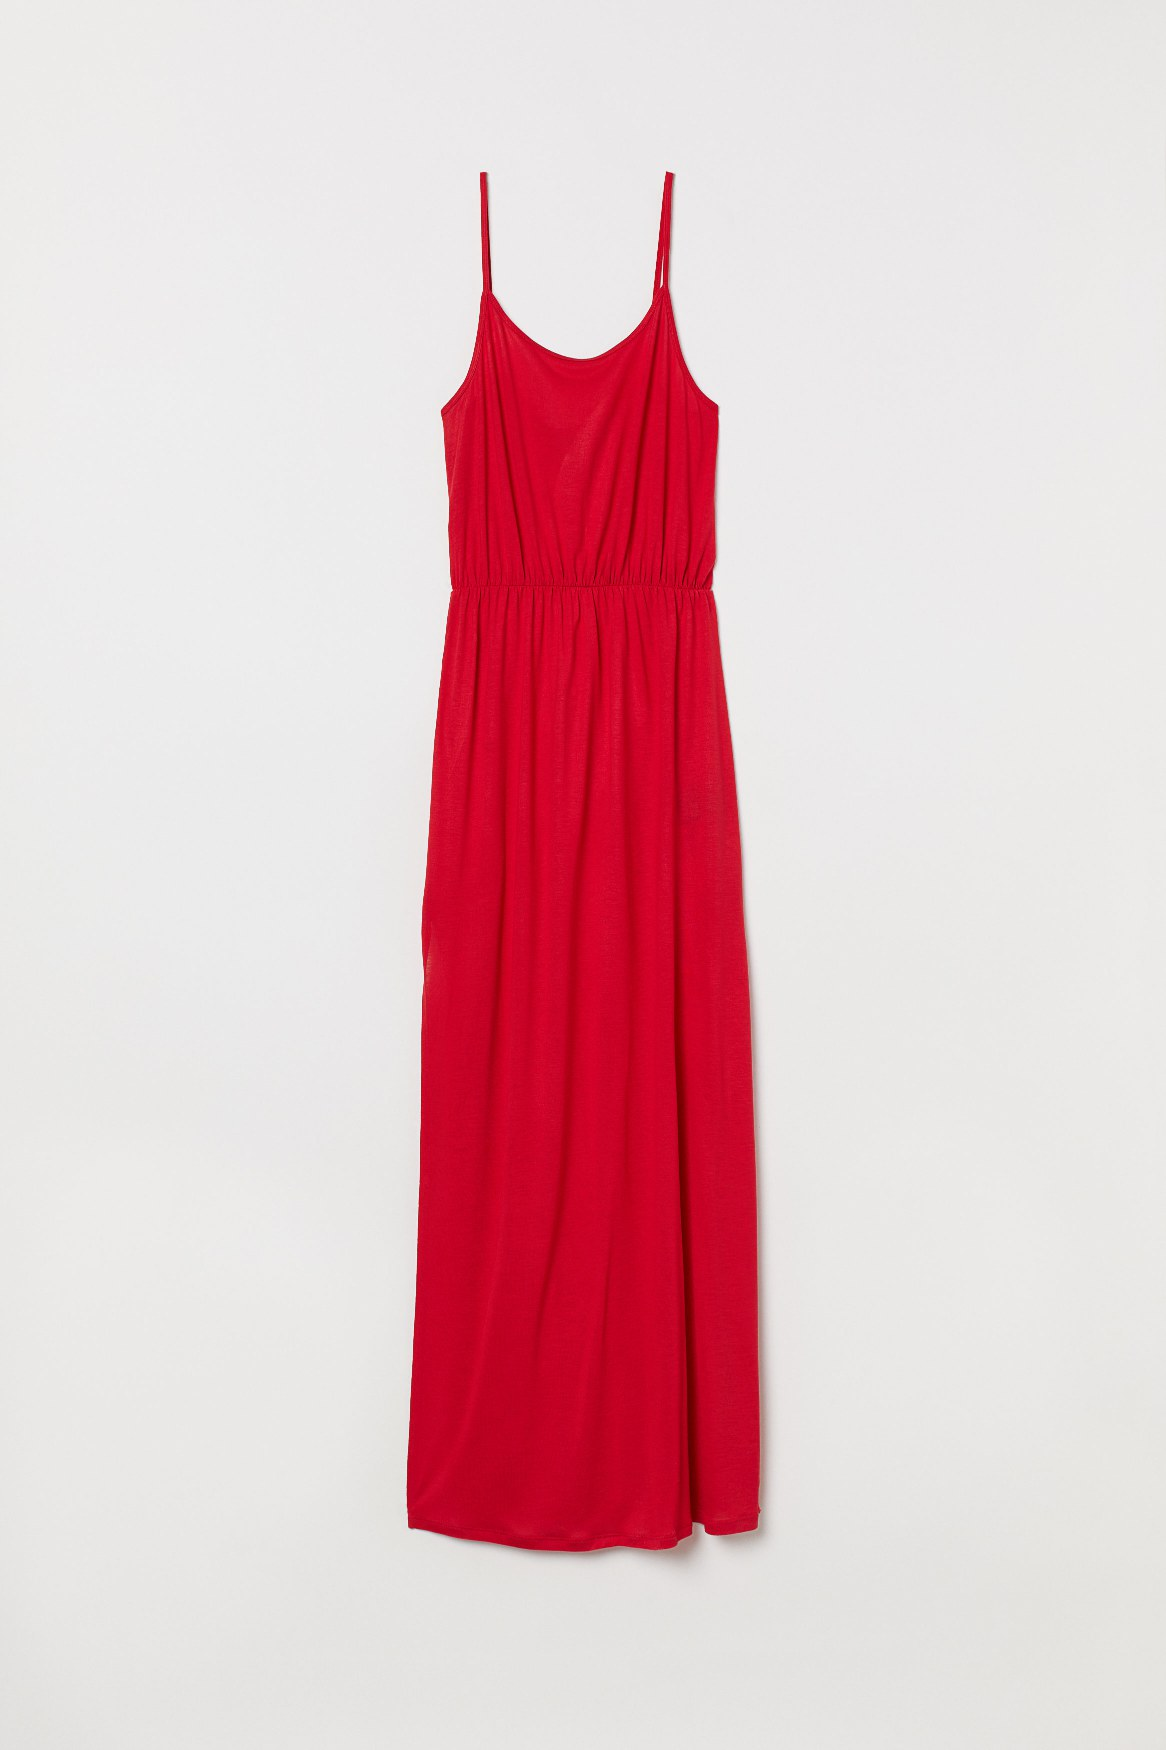

ID: 212629035, Colour: Red, Price: 51.0, Score: 0.54384172


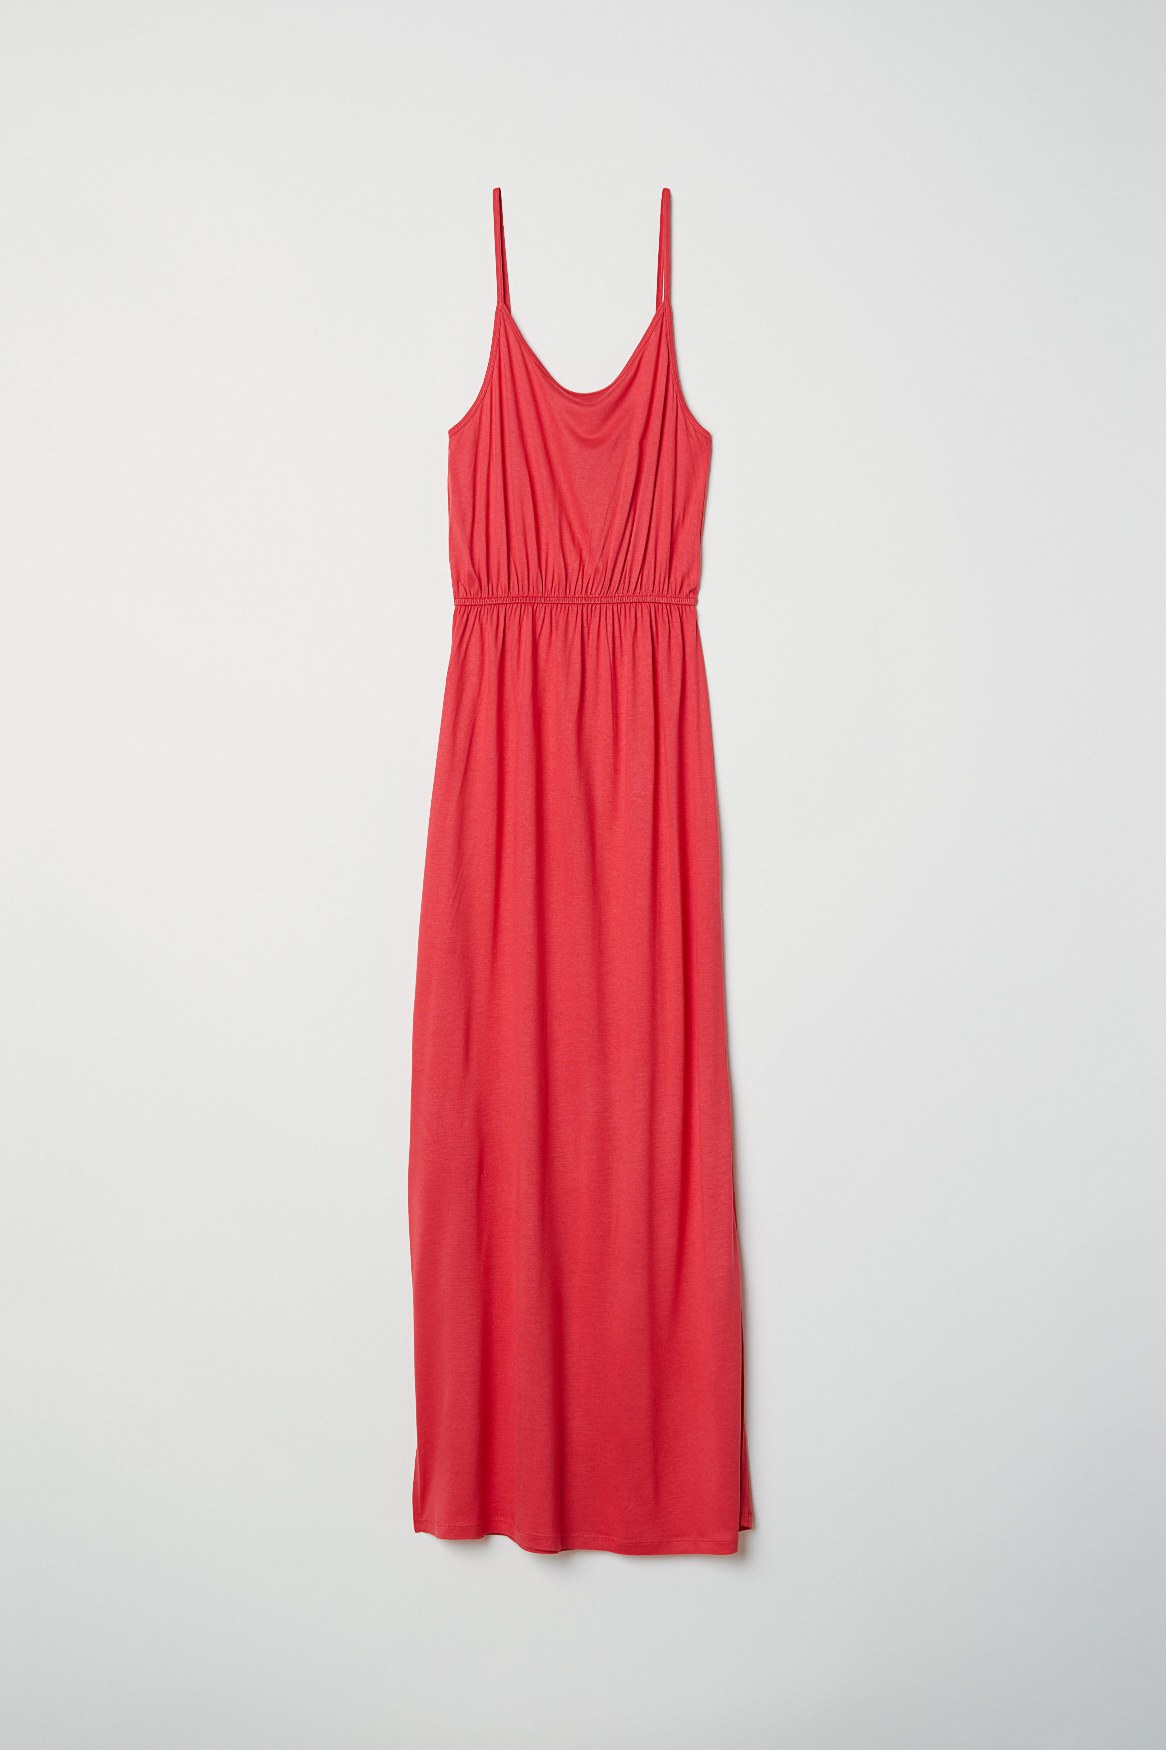

ID: 212629040, Colour: Dark Red, Price: 51.0, Score: 0.540956616


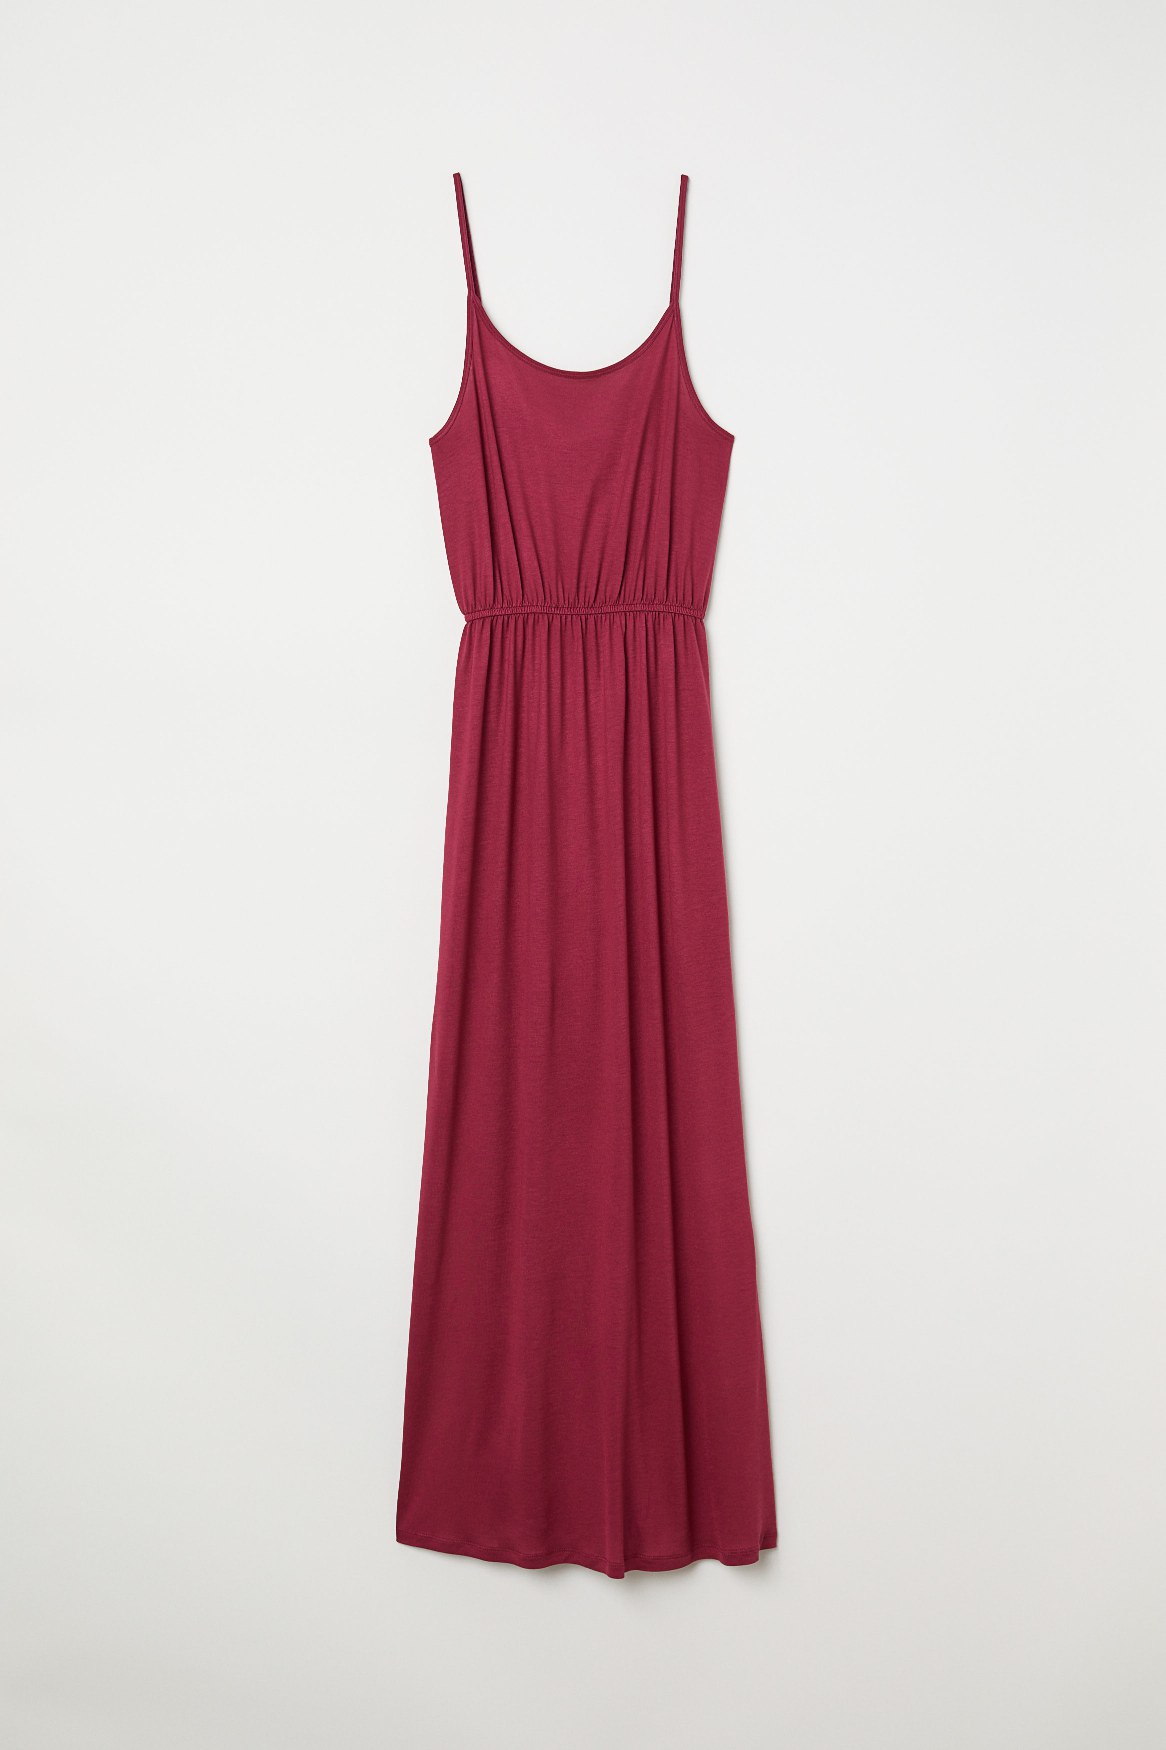

In [ ]:
# display images for query matches
from IPython.display import Image, display

# Iterate through the matches from your Pinecone query
for match in query_response['matches']:
    print(f"ID: {match['id']}, Colour: {match['metadata']['colour']}, Price: {match['metadata']['price']}, Score: {match['score']}")

    # Use the function to get the image path
    image_path = get_image_path_by_id((match['id']), df_data)

    if image_path:
        # Display the image if the path was found
        display(Image(filename=image_path))
    else:
        print("Image path not found.")